The first necessary step is to import all the necessary libraries to conduct our data analysis

In [60]:
#Import Statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
#Model imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import r2_score
import numpy as np

This dataset was found and used from the following open-source site for datasets:
https://www.kaggle.com/datasets/camnugent/california-housing-prices

First, lets load the dataset into a Pandas DataFrame titled "df"

In [61]:
df = pd.read_csv('housing.csv')


Next, lets get an idea on what our dataset looks like. Lets view the first 5 rows here

In [62]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Let's conduct some initial data cleaning. Let's first analyze the dataset, checking for any duplicates.

In [63]:
row_num = len(df)
duplicates = len(df.drop_duplicates())
print("Number of Rows: " + str(row_num))
print("Number of Rows Without Duplicates: " + str(duplicates))

Number of Rows: 20640
Number of Rows Without Duplicates: 20640


Great! There seems to be no duplicates. Now let's analyze the dataset, checking for any null values

In [64]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Interesting. total_bedroooms has 207 null values. Total_bedrooms is something that changes in accordance to other features of the house, so it wouldn't be smart to just take a mathematical mean or median to impute here. Lets use K-Nearest Neighbors imputation to impute the data

In [65]:
# Initialize KNN Imputer with a specified number of neighbors
imputer = KNNImputer(n_neighbors=5)

# Apply KNN Imputer to all numerical columns (including total_bedrooms) while retaining categorical columns
df_imputed = df.copy()

# Identify all numerical columns
numerical_columns = df_imputed.select_dtypes(include=['float64', 'int64']).columns

# Apply KNN Imputer to the entire dataframe's numerical columns
df_imputed[numerical_columns] = imputer.fit_transform(df_imputed[numerical_columns])

# Checking the result of the imputation
print("Number of missing values after KNN Imputation:")
print(df_imputed.isnull().sum())

Number of missing values after KNN Imputation:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


Next, df_imputed is almost ready to go! Ocean_proximity is a categorical column, so before moving onto anything else, let's first convert the categories into integers so we can work with it better.

In [66]:
ocean_proximity_mapping = {
    'NEAR BAY': 0,
    'INLAND': 1,
    'NEAR OCEAN': 2,
    'ISLAND': 3,
    '<1H OCEAN': 4
}

df_imputed['ocean_proximity'] = df_imputed['ocean_proximity'].map(ocean_proximity_mapping)

print("Unique values in 'ocean_proximity' after manual encoding:")
print(df_imputed['ocean_proximity'].unique())

Unique values in 'ocean_proximity' after manual encoding:
[0 4 1 2 3]


In [67]:
df_imputed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0


Great! Now everything looks like what we want it to be. Let's learn more about our data through graphs now!

Exploratory Data Analysis

Lets start by summarizing the dataset to understand its basic properties

In [68]:
df_imputed.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.573663,1425.476744,499.539680,3.870671,206855.816909,2.346221
std,2.003532,2.135952,12.585558,2181.615252,420.411735,1132.462122,382.329753,1.899822,115395.615874,1.553134
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,1.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,2.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,4.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000


This shows that there's significant variability in both population density and housing characteristic, with house values capped at $500,000. Additionally, the average median income indicates economic disparity across regions, which may influence housing trends.

Let's look more into the relationships between different features using a Correlation Matrix now

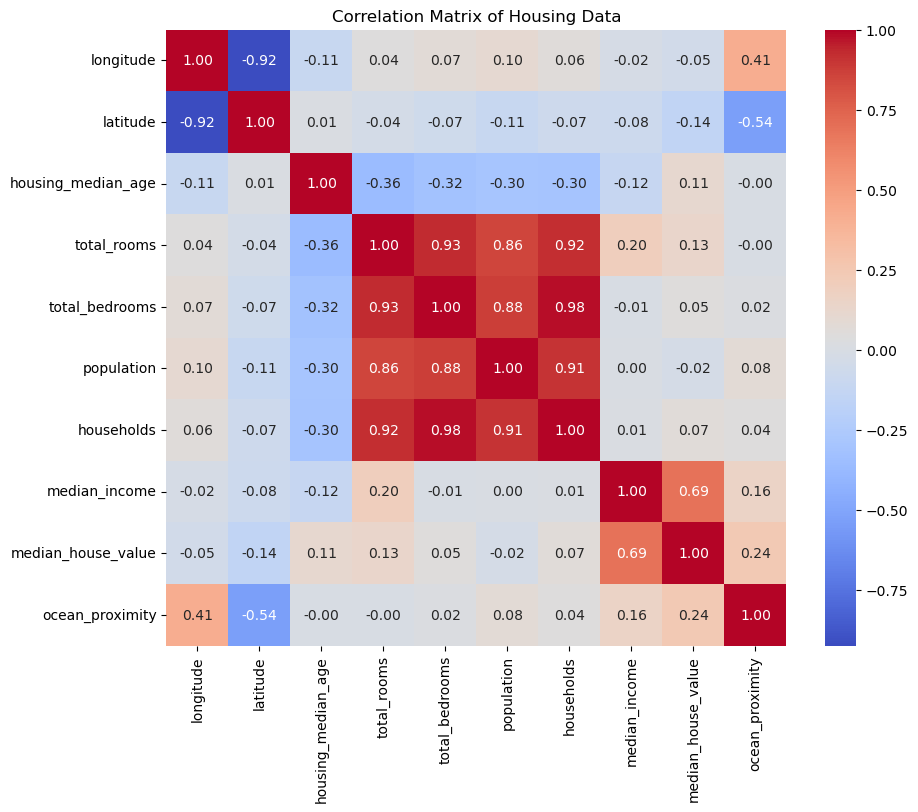

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Housing Data')
plt.show()

After looking at the correlation matrix, we can see that median_income has a positive correlation with median_house_value (0.69) which shows that people with a higher median income tend to spend more on their houses. On top of that, total_rooms and households is also highly correlated (0.92), which makes sense as larger households would need more rooms for people to stay in. One more insight that can be seen is that ocean_proximity has a negative correlation with latitude, which means that homes closer to the ocean are closer to the south. 

Now lets look at some outliers for features such as median_income and total_bedrooms to see if there's any extreme outliers within the two

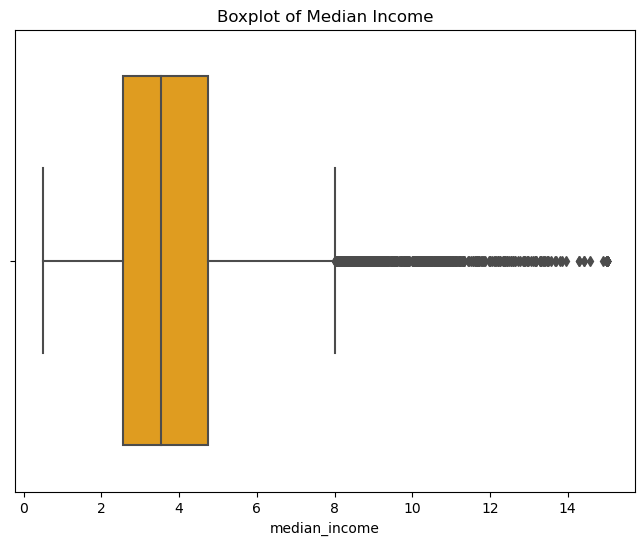

In [70]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_imputed['median_income'], color='orange')
plt.title('Boxplot of Median Income')
plt.show()

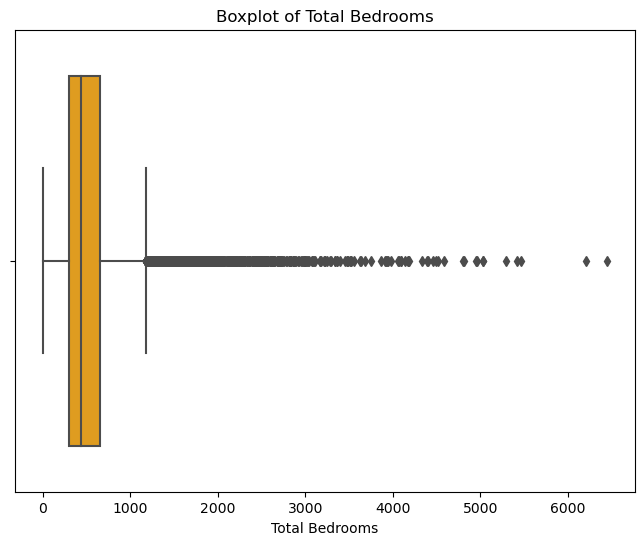

In [71]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_imputed['total_bedrooms'], color='orange')
plt.title('Boxplot of Total Bedrooms')
plt.xlabel('Total Bedrooms')
plt.show()

Median Income: Based on the information given in the boxplot, it appears that many regions have a median income that is about $2,500 to $6,000 and there's data which shows that there are regions with much higher median incomes(a high of $15,000) for instance in some densely populated and also wealthy regions of the United States such as certain parts of the Bay Area or coastal cities. It is sufficient to say then, that the outliers are also important to check as they can drive changes in the pricing of houses within the areas.

Total Bedrooms: Boxplot shows that for most regions, the total number of rooms ranges from 300 to 1000 rooms, but many regions sometimes exceed 3,000, and there's a few extreme points above 6,000. It's very likely that these extreme points correspond to regions that are too crowded because of residential settlements that are complex like the city or apartments that are not isolated. These outliers could cause skew

Now lets make a bar graph to look more into the effects of ocean proximity on median house value.

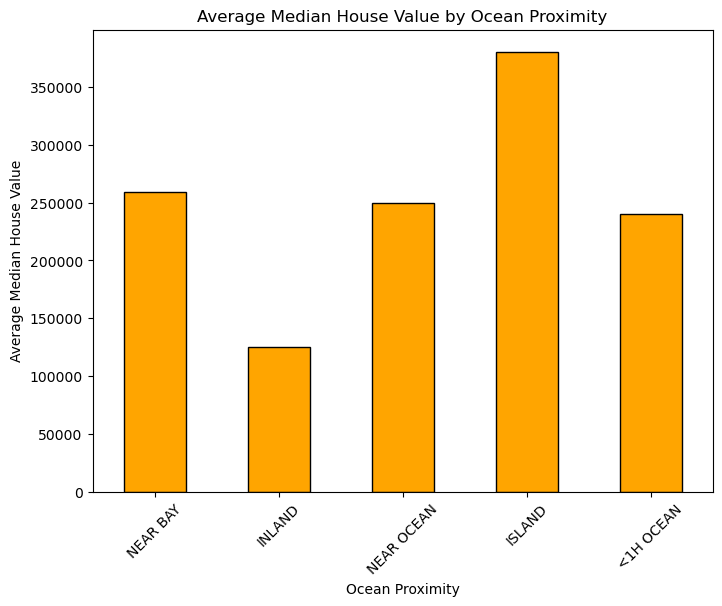

In [72]:
house_value_by_proximity = df_imputed.groupby('ocean_proximity')['median_house_value'].mean()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
house_value_by_proximity.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average Median House Value by Ocean Proximity')
plt.xlabel('Ocean Proximity')
plt.ylabel('Average Median House Value')
plt.xticks([0, 1, 2, 3, 4], ['NEAR BAY', 'INLAND', 'NEAR OCEAN', 'ISLAND', '<1H OCEAN'], rotation=45)
plt.show()

This bar chart shows us that Island regions have a much higher median house value than any other region, and inland houses tend to have the least median house value. The other 3 categories tend to have around the same median house value

**Machine Learning Preparation/Model**

**Train/Test Split**

In [73]:
# Define features and target (X and y respectively)
X = df_imputed.drop(columns=['median_house_value'])  # Only drop the target variable
y = df_imputed['median_house_value']

# one hot encoding for ocean proximity
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Now the data is in an entirely numerical format, which is what we need to begin our machine learning model. Our aim is make a regression model that can predict the value of a house based on the other features in the datasets. We will use a Random Forest Regression model to do so.

In [83]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 2420727042.116059
R-squared: 0.8152693485536358
Root Mean Squared Error: 49200.88456639839


These error values aren't horrible but let's see if some improvement is possible. Let's do some K fold cross validiation to improve our models ability to predict on non test/train data.

In [84]:
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_folds, scoring='r2')

print("Cross-Validation Scores: ", cv_scores)
print("Avg CV Score: ", cv_scores.mean())
print("Standard Deviation of CV: ", cv_scores.std())

Cross-Validation Scores:  [0.80950256 0.82057694 0.81377412 0.81256472 0.8216946 ]
Avg CV Score:  0.8156225907550411
Standard Deviation of CV:  0.004725188568264741


The results of our CV is good!

There is a slight improvement in our error metrics. Now let's look at feature importance and visualize some predictions

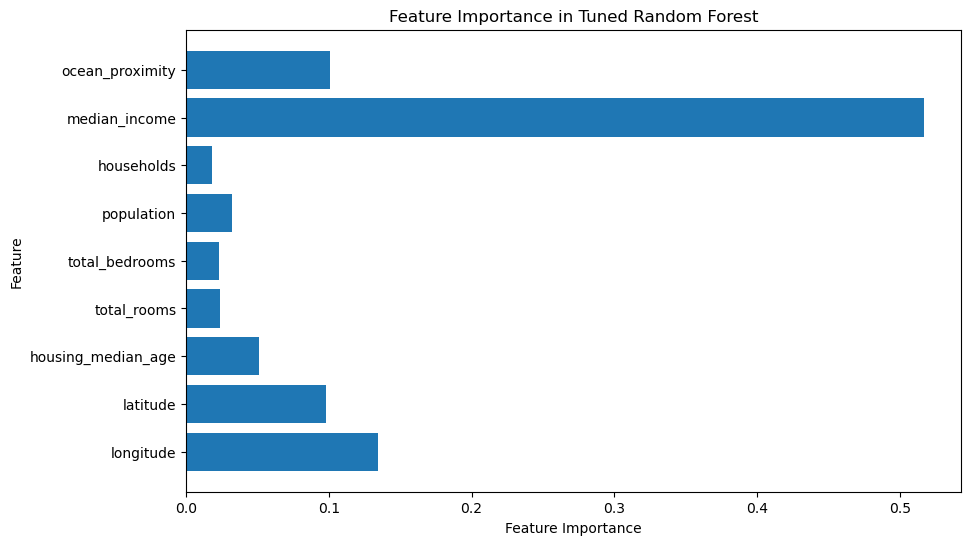

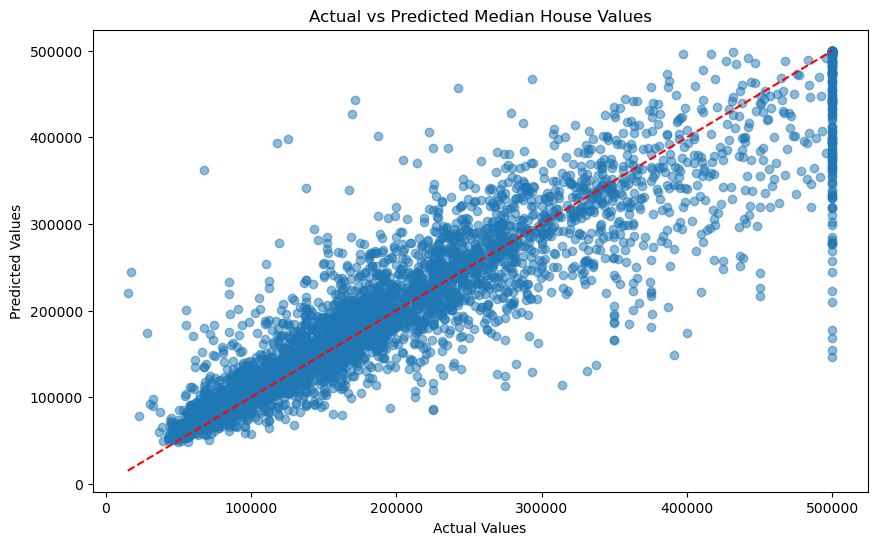

In [85]:
feature_importances = rf_model.feature_importances_
feature_names = X.columns

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Tuned Random Forest")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Median House Values")
plt.show()

The feature importance analysis highlights that median_income is the most influential predictor of housing prices, significantly outweighing all other features. This result aligns with expectations, as household income is a primary driver of housing affordability and demand. Geographic factors, such as longitude and latitude, also play a notable role, reflecting regional variations in housing prices across California. Surprisingly, ocean_proximity, while relevant, has less influence than anticipated, suggesting that income and location are stronger determinants. Features like total_rooms and population contribute minimally, indicating that aggregate counts may be less predictive than relative measures or ratios. These insights provide a clearer understanding of the factors shaping California's housing market.

**Conclusion**

After performing K-Fold Cross-Validation, the Random Forest Regression model demonstrated consistent performance with an average R-squared score of approximately 0.81, aligning well with the test set evaluation. This indicates that the model generalizes effectively across different subsets of the training data, with minimal variability between folds. As a result, the model was finalized using the entire training set and evaluated on the test set to ensure robustness.

The finalized model achieved a R-squared score of 0.815 on the test set, confirming its ability to explain over 81% of the variance in housing prices. These results emphasize the reliability of the model in predicting housing prices based on features such as median income, geographic location, and other factors. With its strong performance and validated consistency, the model is now ready for deployment in predictive tasks or further analysis.